In [1]:
import numpy as np
import cv2
import glob, os
import matplotlib.pyplot as plt

# Undistort Images

In [13]:
# Implement the number of vertical and horizontal corners
nb_vertical = 9
nb_horizontal = 6

patternSize = (nb_vertical,nb_horizontal)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, patternSize[0]*patternSize[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints_l = [] # 3d point in real world space
imgpoints_l = [] # 2d points in image plane.
objpoints_r = [] # 3d point in real world space
imgpoints_r = [] # 2d points in image plane.


images_l = glob.glob('data/Stereo_calibration_images/left*.png')
images_l = sorted(images_l)

images_r = glob.glob('data/Stereo_calibration_images/right*.png')
images_r = sorted(images_r)

assert images_l
assert images_r

for i, fname in enumerate(images_l):
    img_l = cv2.imread(images_l[i])
    gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    
    retl, cornersl = cv2.findChessboardCorners(gray_l, patternSize, cv2.CALIB_CB_ADAPTIVE_THRESH
                                             + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    img_r = cv2.imread(images_r[i])
    gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
    
    retr, cornersr = cv2.findChessboardCorners(gray_r, patternSize, cv2.CALIB_CB_ADAPTIVE_THRESH
                                             + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    # If found, add object points, image points (after refining them)
    if retl is True:
        objpoints_l.append(objp)
        imgpoints_l.append(cornersl)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img_l, (nb_vertical,nb_horizontal), cornersl,retl)
        cv2.imshow('img_l',img_l)

    if retr is True:
        objpoints_r.append(objp)
        imgpoints_r.append(cornersr)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img_r, (nb_vertical,nb_horizontal), cornersr,retr)
        cv2.imshow('img_r',img_r)
    
    
    cv2.waitKey(30)

cv2.destroyAllWindows()

In [14]:
# FishEye
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW

In [15]:
# Calibrate Left
N_OK_l = len(objpoints_l)
K_l = np.zeros((3, 3))
D_l = np.zeros((4, 1))
rvecs_l = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK_l)]
tvecs_l = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK_l)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints_l,
        imgpoints_l,
        gray_l.shape[::-1],
        K_l,
        D_l,
        rvecs_l,
        tvecs_l,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

In [16]:
# Calibrate Right
N_OK_r = len(objpoints_r)
K_r = np.zeros((3, 3))
D_r = np.zeros((4, 1))
rvecs_r = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK_r)]
tvecs_r = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK_r)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints_r,
        imgpoints_r,
        gray_r.shape[::-1],
        K_r,
        D_r,
        rvecs_r,
        tvecs_r,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

In [17]:
def undistort(img, K, D):
    DIM = img.shape[:2]
    DIM = DIM[::-1]
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

Text(0.5, 1.0, 'Undistorted image Right')

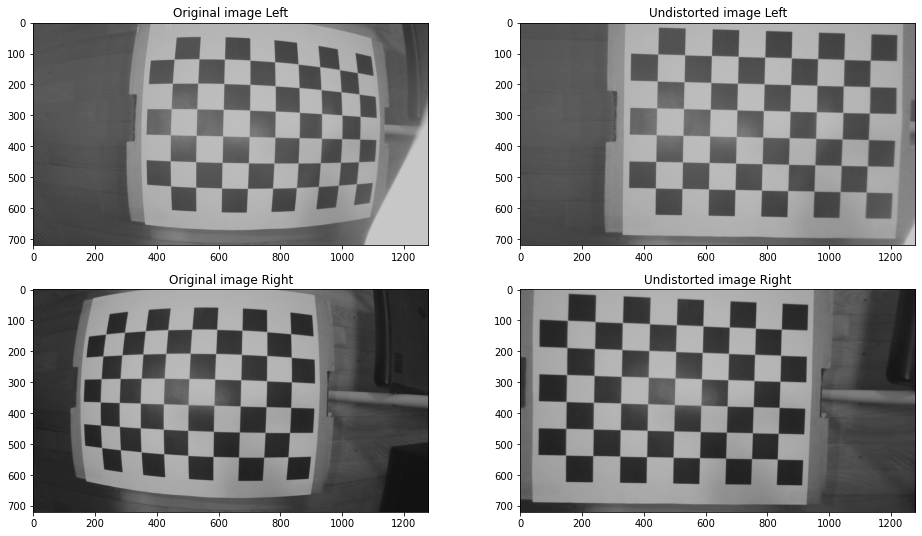

In [18]:
img_l = cv2.imread(images_l[45])
img_r = cv2.imread(images_r[45])

# undistort
dst_l = undistort(img_l, K_l, D_l)
dst_r = undistort(img_r, K_r, D_r)

# Plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
ax[0, 0].imshow(img_l[...,[2,1,0]])
ax[0, 0].set_title('Original image Left')
ax[0, 1].imshow(dst_l[...,[2,1,0]])
ax[0, 1].set_title('Undistorted image Left')

ax[1, 0].imshow(img_r[...,[2,1,0]])
ax[1, 0].set_title('Original image Right')
ax[1, 1].imshow(dst_r[...,[2,1,0]])
ax[1, 1].set_title('Undistorted image Right')

# Rectifying (Not using for now)

In [10]:
def rectify(l_img_crop, r_img_crop, objpoints, imgpoints_l, imgpoints_r, newcameramtx_l, dist_l, newcameramtx_r, dist_r, img_shape):
    ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate([objpoints], [imgpoints_l], [imgpoints_r],
                        newcameramtx_l, dist_l, newcameramtx_r, dist_r, img_shape)
        
    # rectification and undistortion maps which can be used directly to correct the stereo pair
    (rectification_l, rectification_r, projection_l,
        projection_r, disparityToDepthMap, ROI_l, ROI_r) = cv2.stereoRectify(
            M1, d1, M2, d2, img_shape, R, T,
            None, None, None, None, None,
            #cv2.CALIB_ZERO_DISPARITY,                  # principal points of each camera have the same pixel coordinates in rect views
            alpha=1)                                   # alpha=1 no pixels lost, alpha=0 pixels lost
    
    leftMapX, leftMapY = cv2.initUndistortRectifyMap(
        M1, d1, rectification_l, projection_l,
        img_shape, cv2.CV_32FC1)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(
        M2, d2, rectification_r, projection_r,
        img_shape, cv2.CV_32FC1)
    
    ### REMAPPING ###
    imglCalRect = cv2.remap(l_img_crop, leftMapX, leftMapY, cv2.INTER_LINEAR)
    imgrCalRect = cv2.remap(r_img_crop, rightMapX, rightMapY, cv2.INTER_LINEAR)
    
    return imglCalRect, imgrCalRect

In [19]:
# calculate point arrays for epipolar lines
lineThickness = 1
lineColor = [0, 255, 0]
numLines = 20
interv = round(img_l[0] / numLines)
x1 = np.zeros((numLines, 1))
y1 = np.zeros((numLines, 1))
x2 = np.full((numLines, 1), (3*img_l[1]))
y2 = np.zeros((numLines, 1))
for jj in range(0, numLines):
    y1[jj] = jj * interv
y2 = y1

# Create results folder
if not os.path.exists('rs_rect'):
    os.makedirs('rs_rect')

TypeError: type numpy.ndarray doesn't define __round__ method

In [12]:
for i in range(len(images_l)):
    # Left Image
    l_img = cv2.imread(images_l[i])
    l_img = cv2.undistort(l_img, mtx_l, dist_l, None, newcameramtx_l)
    l_img = l_img[y:y+h, x:x+w]

    # Right Image
    r_img = cv2.imread(images_r[i])
    r_img = cv2.undistort(r_img, mtx_r, dist_r, None, newcameramtx_r)
    r_img = r_img[y:y+h, x:x+w]
    
    h, w, c = l_img.shape
    img_shape = (w, h)
    imglCalRect, imgrCalRect = rectify(l_img, r_img, objpoints_l[i], imgpoints_l[i], imgpoints_r[i], 
                                       newcameramtx_l, dist_l, newcameramtx_r, dist_r, img_shape)

    ### SHOW RESULTS ###
    numpyHorizontalCalibRect = np.hstack((imglCalRect, imgrCalRect))
    
    for jj in range(0, numLines):
        cv2.line(numpyHorizontalCalibRect, (int(x1[jj]), int(y1[jj])), (int(x2[jj]), int(y2[jj])),
                 lineColor, lineThickness)
    
    # Save images
    cv2.imwrite('rs_rect/rect_{}.png'.format(i), numpyHorizontalCalibRect)
plt.figure(figsize = (14,14))
plt.imshow(numpyHorizontalCalibRect)

NameError: name 'mtx_l' is not defined